# Page rank

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import networkx as nx
import graphviz as gv
import random

from typing import List

## Network classes

In [132]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.outgoingLinks = []
        self.incomingLinks = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkFrom(self, other):
        """Adds a link from another page, ending at this page"""
        self.incomingLinks.append(other)
    
    def addLinkTo(self, other):
        """Adds a link to another page, starting from this page"""
        self.outgoingLinks.append(other)
        other.addLinkFrom(self)
        
    def addLinksTo(self, *args):
        """Adds a link to another page, starting from this page"""
        for page in args:
            self.addLinkTo(page)
        
    def outDegree(self):
        """Returns the amount of links this page has to other pages, i.e. its out-degree"""
        return len(self.outgoingLinks)
    
    def getName(self):
        return self.name
    
    def linksTo(self, other) -> bool:
        return other in self.outgoingLinks

In [134]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
        
        # Whether the dataframe is out of date
        self.old_df = True
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
        
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
        # Dataframe is out of date now
        self.old_df = True
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
            
    def debugRanking(self):
        """
        Computes the sum of the rank of all pages in the network, which *should* return 1.
        """
        rankSum = 0
        for page in self:
            rankSum += page.rank
        print(rankSum)
        
    def testUnconnected(self):
        """
        Prints if there are unconnected pages (pages with no link to or from them) in the network.
        """
        for page in self:
            if (len(page.incomingLinks)==0) & (len(page.outgoingLinks)==0):
                print("Page {} is unconnected".format(page.getName()))
        print("All unreported pages are connected to at least one other node via an incoming/outgoing link.")
        
    def getPage(self, name: str):
        """
        Returns page in this network with this name. 
        """
        for page in self:
            if (page.getName() == name):
                return page
        print("Error, no page with name " + name + " found!")
    
    # ----------------------------------------------------------
    # --------------------- VISUALIZATION ----------------------
    # ----------------------------------------------------------
    
    # ------------------- NODE-LINK DIAGRAMS ------------------- 
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.outgoingLinks:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.outgoingLinks) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self, names=False):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by rank
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.outgoingLinks:
                f.edge(str(page), str(other))

        return f
    
    # ----------------------- STATISTICS -----------------------
    def updateDf(self):
        """Update pandas DataFrame of this network."""
        
        # Prepare a dataframe
        df = pd.DataFrame(columns=['Name', 'Outdegree', 'Indegree'])
        
        df['Name'] = list(map(Page.getName, self.pages))
        df['Outdegree'] = list(map(Page.outDegree, self.pages))
        df.fillna(0, inplace=True)
        
        # Count indegree of every page
        for page in self:
            for link in page.outgoingLinks:
                df.at[link.id, 'Indegree'] += 1
        
        # Update dataframe
        self.df = df
        self.old_df = False
        
    def plot_outdegrees(self):
        """Plots a histogram of the outdegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Outdegree'], kde=False, rug=True)
        ax.set_xlabel("Outdegree (number of links to other pages)")
        ax.set_ylabel("Frequency")
        
    def plot_indegrees(self):
        """Plots a histogram of the indegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Indegree'], kde=False, rug=True)
        ax.set_xlabel("Indegree (number of links to this page from other pages)")
        ax.set_ylabel("Frequency")
        
    def describe(self):
        """Prints a table of summary statistics of this network."""
        if self.old_df:
            self.updateDf()
            
        return self.df.describe()
    
    def getDf(self):
        """Returns the dataframe of this network, updates it when needed."""
        if self.old_df:
            self.updateDf()
            
        return self.df
    
    def sinks(self):
        """Returns the sinks of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Outdegree'] == 0]
        
    def sources(self):
        """Returns the sources of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Indegree'] == 0]

### Example Wikipedia-YouTube-Twitter

In [4]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [5]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [6]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [7]:
yt.incomingLinks

[Wikipedia, Twitter]

In [8]:
yt.outgoingLinks

[Twitter]

### Example California Network

In [9]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [10]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [11]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rankCR(network: Network, steps: int = None, alpha: float = 0.5, epsilon: float = 1e-9, qis: List[float] = None): # rankCR = rankCertainRestart
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        initRanks = PageRanker.calculateInitialRanking(network)
        
        if qis == None:
            PageRanker.calculateJumpingProbabilities(network)
        else:
            for i, page in enumerate(network):
                page.q = qis[i]
        
        if steps != None:
            for _ in range(0, steps):
                PageRanker.stepRankCR(network, alpha)
        
        else:
            n = 0
            oldRanks = initRanks
            while True:
                n += 1
                newRanks = PageRanker.stepRankCR(network, alpha)
#                 print(newRanks)
                d = max([abs(newRanks[page] - oldRanks[page]) for page in network])

                if d < epsilon:
                    break
                
                oldRanks = newRanks
                    
#             print(f'Iterations: {n}')
            return n
    
    @staticmethod
    def stepRankCR(network: Network, alpha: float):
        """
        Does one step of the random-restart ranking
        """
        newRanks = {}
        for page in network:
            newRanks[page] = 0
            # Sum dot product of column and stationary distribution
            for other in network:
                if other.outDegree() > 0:
                    newRanks[page] += other.rank * page.q * (1 - alpha)
                else:
                    newRanks[page] += other.rank * page.q
                if other.linksTo(page):
                    newRanks[page] += other.rank * alpha / other.outDegree()

        for page in network:
            page.rank = newRanks[page]
            
        return newRanks
    
    @staticmethod
    def rank(network: Network, steps: int = None, alpha: float = 0.5, epsilon: float = 1e-9, qis: List[float] = None):
        """
        Ranks a network via the PageRank algorithm.
        Runtime O(steps * #pages * max. incoming links for a page)
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        initRanks = PageRanker.calculateInitialRanking(network)
        
        if qis == None:
            PageRanker.calculateJumpingProbabilities(network)
        else:
            for i, page in enumerate(network):
                page.q = qis[i]
        
        if steps != None:
            for _ in range(0, steps):
                PageRanker.stepRank(network, alpha)
            
        else:
            n = 0
            oldRanks = initRanks
            while True:
                n += 1
                newRanks = PageRanker.stepRank(network, alpha)
#                 print(newRanks)
                d = max([abs(newRanks[page] - oldRanks[page]) for page in network])

                if d < epsilon:
                    break
                
                oldRanks = newRanks
                    
#             print(f'Iterations: {n}')
            return n

        rankSum = sum([page.rank for page in network])
        for page in network:
            page.rank = page.rank/rankSum

    @staticmethod
    def stepRank(network: Network, alpha: float):
        """
        Does one step of the normalized ranking
        """
        newRanks = {}
        for page in network:
            newRanks[page] = 0
            for other in page.incomingLinks:
                newRanks[page] += other.rank / other.outDegree()
            newRanks[page] *= alpha
            newRanks[page] += (1-alpha) * page.q

        for page in network:
            page.rank = newRanks[page]
            
        return newRanks
    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1.0 / network.size()
#             print("initial rank for " + str(network.size()) + " pages is " + str((1.0 / network.size())) )
            # When looking at the above print command for large networks, the sum doesn't necessarily add to 1 perfectly
            # anymore due to rounding errors
        
        return {page:1.0/network.size() for page in network}
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1.0 / network.size()


### Example Wikipedia-YouTube-Twitter Calculation

In [12]:
PageRanker.calculateInitialRanking(internet)

{YouTube: 0.3333333333333333,
 Wikipedia: 0.3333333333333333,
 Twitter: 0.3333333333333333}

#### Wikipedia-YouTube-Twitter with the Certain Restart Version

In [13]:
PageRanker.rankCR(internet)
internet.showRanking()
internet.debugRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666663
Twitter: 0.41666666666666663
0.9999999999999999


As long as the network does not have a sink, the ranks seem to be calculated correctly and still sum to 1. 

#### Wikipedia-YouTube-Twitter with Normalizer Version

In [14]:
PageRanker.rank(internet) 

2

In [15]:
internet.showRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666666
Twitter: 0.41666666666666663


In [16]:
internet.debugRanking() # This one is the one with the normalizer feature, naturally it sums perfectly to 1 for this simple network

0.9999999999999999


### Example California Network Calculation

#### Certain Restart Version

In [17]:
# slow (this is only 1 iteration!)
# PageRanker.rankCR(california, 1, 0.5)
# california.showRanking()
# california.debugRanking()

#### Normalizer Version

In [18]:
PageRanker.rank(california)
california.showRanking()
california.debugRanking()

http://www.berkeley.edu/: 0.0014796631968201919
http://www.caltech.edu/: 0.00042677764977363115
http://www.realestatenet.com/: 6.973437949899235e-05
http://www.ucsb.edu/: 0.0007300449721356065
http://www.washingtonpost.com/wp-srv/national/longterm/50states/ca.htm: 7.760761589403974e-05
http://www-ucpress.berkeley.edu/: 0.00016991007769839912
http://www.ucr.edu/: 0.0003377886496539933
http://www.tegnetcorporation.com/: 5.173841059602649e-05
http://www.research.digital.com/SRC/virtual-tourist/California.html: 0.0006790729266729559
http://www.leginfo.ca.gov/calaw.html: 0.001057112928319848
http://www.csun.edu/: 0.00028766475264429425
http://www.calpoly.edu/: 0.00020652805716495217
http://www.calbar.org/: 0.00031850516012709676
http://ideas.uqam.ca/ideas/data/fthcalaec.html: 5.173841059602649e-05
http://www.sen.ca.gov/: 0.0006930088161040139
http://www.csupomona.edu/: 0.00024010624197873823
http://www.csuchico.edu/: 0.00018335040967153938
http://www.calacademy.org/: 0.0007159022632606338
h

http://www.elite.net/~tjohnson/: 5.173841059602649e-05
http://www.autodesk.com/compinfo/visinfo/visinfo.htm: 5.173841059602649e-05
http://www.onlinebusiness.com/CityPages/states/ca/n_california.shtml: 5.173841059602649e-05
http://www.ecst.csuchico.edu/~billray/: 5.173841059602649e-05
http://www.tu-harburg.de/rzt/rzt/it/sofie/node9.html: 5.173841059602649e-05
http://a1.com/pebooks/vlinks.htm: 5.173841059602649e-05
http://pw1.netcom.com/~cgunther/index.html: 5.173841059602649e-05
http://www.takethelead.fullerton.edu/BachMast.htm: 5.173841059602649e-05
http://psych.fullerton.edu/ungrad.html: 5.173841059602649e-05
http://www5.fullerton.edu/titan/DTcampus.html: 5.173841059602649e-05
http://sbaeweb2.fullerton.edu/~finance/fac_advs.htm: 5.173841059602649e-05
http://titan.ecs.fullerton.edu/~marcos2/: 5.173841059602649e-05
http://business.fullerton.edu/~msis/mscschd.html: 5.173841059602649e-05
http://biology.fullerton.edu/courses/: 5.173841059602649e-05
http://business.fullerton.edu/~finance/pt

http://www.agpub.on.ca/agsite_4.htm: 5.173841059602649e-05
http://www.simmons.edu/~mitchell/tomtips.html: 5.173841059602649e-05
http://members.aol.com/healthwrtr/general.htm: 5.173841059602649e-05
http://www.fb.com/cafb/secp.htm: 5.173841059602649e-05
http://www.johnnyseeds.com/whatsnew.html: 5.173841059602649e-05
http://www.state.sc.us/scda/farmers.htm: 5.173841059602649e-05
http://www.io.com/neighbor/veg.html: 5.173841059602649e-05
http://www.rit.edu/~njc9786/linkpage.htm: 5.173841059602649e-05
http://www.bguide.com/askb/askb.fw.html: 5.173841059602649e-05
http://southernfood.miningco.com/msub10.htm: 5.173841059602649e-05
http://www.pcug.co.uk/~owls/edibilia.html: 5.173841059602649e-05
http://sunsite.unc.edu/london/agriculture/feedback/dirtfarmer/msg00046.html: 5.173841059602649e-05
http://www.freep.com/fun/food/qweb22.htm: 5.173841059602649e-05
http://vegetablegarden.miningco.com/msubtom.htm: 5.173841059602649e-05
http://www.wildstar.net/~helper/food_drk.htm: 5.173841059602649e-05
h

http://www.lib.siu.edu/swen/cala/calachca.htm: 5.173841059602649e-05
http://www.csuchico.edu/library/elebooks.html: 8.678701132236703e-05
http://www.kumc.edu/MLA/units/chap-mlgsca/: 5.173841059602649e-05
http://www.el-dorado.ca.us/~lib-pl/library.htm: 5.173841059602649e-05
http://sjvls.lib.ca.us/kings/index.html: 5.173841059602649e-05
http://www.californiahistory.com/: 5.173841059602649e-05
http://www.sjvls.lib.ca.us/kings/: 5.173841059602649e-05
http://nora.sfpl.lib.ca.us/gencoll/gencol00.htm: 5.173841059602649e-05
http://www.nocall.org/libraries.html: 5.173841059602649e-05
http://www.sims.berkeley.edu/people/alumni/resources.html: 5.173841059602649e-05
http://www.calibraries.org/: 5.409015653220951e-05
http://www.kimo.com.tw/srch/html/0816102e7.html: 5.173841059602649e-05
http://www.san-andreas-sla.org/other/career.htm: 5.173841059602649e-05
http://users.deltanet.com/users/ggreg/public_html/about.html: 5.173841059602649e-05
http://scow.gslis.ucla.edu/students_a-l/jkim/HTML/JENZWEB.HT

http://www.garlic.com/logs/19970106/wgi.wwwstats.html: 5.173841059602649e-05
http://www.voicenet.com/~vulfy/march.htm: 5.173841059602649e-05
http://www.cyberg8t.com/soundmachine/scores.htm: 5.173841059602649e-05
http://www.yahoo.com/Regional/U_S__States/California/Cities/Valencia/Entertainment_and_Arts/Music/index.html: 5.173841059602649e-05
http://www.geocities.com/~truthisfree/guard.htm: 5.82057119205298e-05
http://www.rusd.k12.ca.us/Schools/links.html: 5.173841059602649e-05
http://www.mercies.com/music/links.htm: 5.173841059602649e-05
http://members.aol.com/RCCBand1/fantasia.html: 7.760761589403974e-05
http://www.geocities.com/Vienna/Strasse/3554/: 5.82057119205298e-05
http://www.geocities.com/Paris/1627/: 6.036147902869757e-05
http://www.jetlink.net/~clintg/cglinks.html: 5.173841059602649e-05
http://www.mccga.org/links.htm: 5.173841059602649e-05
http://prozac.cwru.edu/dvp/drumcorp.html: 5.173841059602649e-05
http://home.earthlink.net/~mcelearn/conquistadors/links.html: 5.1738410596

### Edge Case: Source -> Sink

#### Normalizer Version

In [19]:
criminal = Network()
page1 = Page("Source")
page2 = Page("Sink")
page1.addLinkTo(page2)
criminal.addPages(page1, page2)

In [20]:
#criminal.plot0()

In [21]:
PageRanker.rank(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

Source: 0.4
Sink: 0.6
1.0


In [22]:
nx.pagerank(criminal.nxDiGraph(), alpha=0.5, max_iter=10)

{Source: 0.40000009536743164, Sink: 0.5999999046325684}

#### Certain Restart Version

In [23]:
PageRanker.rankCR(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

Source: 0.40000009536743164
Sink: 0.5999999046325684
1.0


### Timo's handsolved network

In [24]:
handsolved = Network()
w1 = Page("Website 1")
w2 = Page("Website 2")
w3 = Page("Website 3")
w4 = Page("Website 4")
w5 = Page("Website 5")

w1.addLinksTo(w2, w3, w4, w5)
w2.addLinksTo(w3, w4, w5)
w3.addLinksTo(w1, w2, w4, w5)
w4.addLinksTo(w2, w3)
w5.addLinkTo(w4)

handsolved.addPages(w1, w2, w3, w4, w5)
#handsolved.plot0()

In [25]:
PageRanker.rankCR(handsolved, 100, 0.5)
handsolved.showRanking()

Website 1: 0.12720848056537118
Website 2: 0.20989399293286243
Website 3: 0.21766784452296845
Website 4: 0.2671378091872795
Website 5: 0.17809187279151964


In [26]:
print(f'Website 1: {36/283}')
print(f'Website 2: {297/1415}')
print(f'Website 3: {308/1415}')
print(f'Website 4: {378/1415}')
print(f'Website 5: {252/1415}')

Website 1: 0.127208480565371
Website 2: 0.20989399293286218
Website 3: 0.2176678445229682
Website 4: 0.26713780918727914
Website 5: 0.17809187279151945


## Visualization of (small) networks

### With networkx

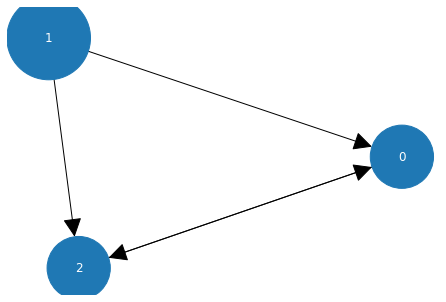

In [27]:
# size based on links
internet.plot1()

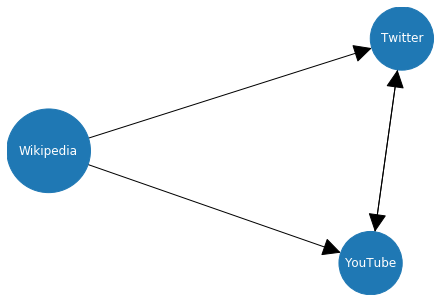

In [28]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

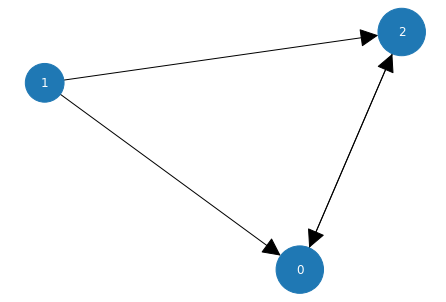

In [29]:
#size based on rank
internet.plot2()

### With graphviz

In [30]:
#internet.plot0()

### Homepage Network

In [163]:
def makeHomepageNetwork(sinkSiteAmount: int = 100):
    homepageNetwork= Network()
    homepage = Page("Homepage")
    for i in range(0,sinkSiteAmount):
        p = Page("test" + str(i))
        homepage.addLinkTo(p)
        homepageNetwork.addPage(p)
    homepageNetwork.addPage(homepage)
    return homepageNetwork

### Endpage Network

In [164]:
# Configurable parameter
def makeEndpageNetowork(sourceSiteAmount: int = 100):
    endpageNetwork = Network()
    endpage = Page("Endpage")
    for i in range(0,sourceSiteAmount):
        p = Page("test" + str(i))
        p.addLinkTo(endpage)
        endpageNetwork.addPage(p)
    endpageNetwork.addPage(endpage)
    return endpageNetwork

## Statistics

In [36]:
internet.sources()

,Name,Outdegree,Indegree
1,Wikipedia,2,0


In [37]:
internet.sinks()

,Name,Outdegree,Indegree


In [38]:
california.sinks()

,Name,Outdegree,Indegree
9,http://www.leginfo.ca.gov/calaw.html,0,155
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
15,http://www.csupomona.edu/,0,36
16,http://www.csuchico.edu/,0,32
33,http://www.ftb.ca.gov/,0,46
...,...,...,...
9655,http://www.fleamarket.net/,0,0
9658,http://remco.com/fun.html,0,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0


In [39]:
california.sources()

,Name,Outdegree,Indegree
7,http://www.tegnetcorporation.com/,11,0
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
79,http://www.mapquest.com/wine/mqinterconnect,1,0
95,http://www.angelfire.com/ca/srcom/index.html,4,0
120,http://www.psn.net/support/access_num.phtml,2,0
...,...,...,...
9659,http://www.spd.louisville.edu/~mejenn01/handy....,1,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0
9662,http://www.meats.net/,0,0


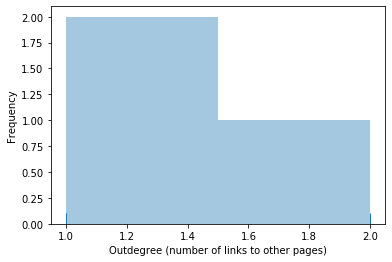

In [40]:
internet.plot_outdegrees()

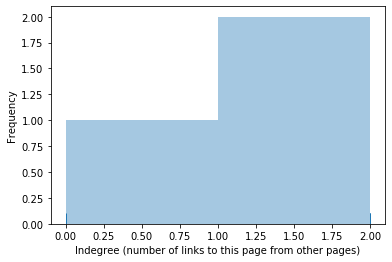

In [41]:
internet.plot_indegrees()

In [42]:
internet.describe()

,Outdegree,Indegree
count,3.000000,3.000000
mean,1.333333,1.333333
std,0.577350,1.154701
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.500000,2.000000
max,2.000000,2.000000


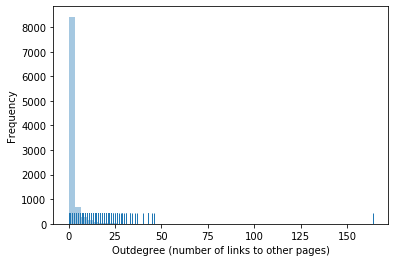

In [43]:
california.plot_outdegrees()

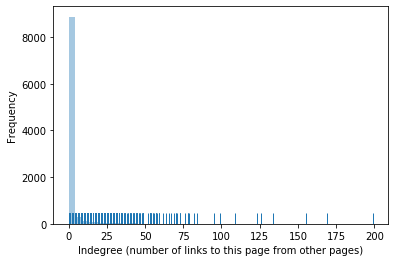

In [44]:
california.plot_indegrees()

In [45]:
california.describe()

,Outdegree,Indegree
count,9664.000000,9664.000000
mean,1.671151,1.671151
std,3.695696,7.457138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,164.000000,199.000000


# More Network Generators

## 10 websites

### Twee of drie verschillende stelsels, Customization: Add third little network of 2 websites and/or add a link from website 8 to these two websites

In [46]:
# #hier kunnen zo'n hashtags voor worden gezet voor verschillende stelsels/links


# Doe "CTRL + /" om een grote sectie te commenten


# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")

# Website1.addLinkTo(Website2)
# Website1.addLinkTo(Website3)
# Website1.addLinkTo(Website4)

# Website2.addLinkTo(Website1)
# Website2.addLinkTo(Website3)
# Website2.addLinkTo(Website4)

# Website3.addLinkTo(Website1)
# Website3.addLinkTo(Website2)
# Website3.addLinkTo(Website4)

# Website4.addLinkTo(Website1)
# Website4.addLinkTo(Website2)
# Website4.addLinkTo(Website3)

# Website5.addLinkTo(Website6)
# Website5.addLinkTo(Website7)
# Website5.addLinkTo(Website8)

# Website6.addLinkTo(Website5)
# Website6.addLinkTo(Website7)
# Website6.addLinkTo(Website8)

# Website7.addLinkTo(Website5)
# Website7.addLinkTo(Website6)
# Website7.addLinkTo(Website8)

# Website8.addLinkTo(Website5)
# Website8.addLinkTo(Website6)
# Website8.addLinkTo(Website7)

# #Website8.addLinkTo(Website9)
# #Website8.addLinkTo(Website10)

# #Website9.addLinkTo(Website10)
# #Website10.addLinkTo(Website9)


# network2Different = Network()
# network2Different.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8)
# #network2Different.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [178]:
def makeClusterNetwork(clusterAmount: int=3, clusterSize: int=10, forwardLinkClusters: bool=True, backwardLinkClusters: bool=True):
    """
    --- Parameters ---
    clusterAmount: Amount of clusters in the network.
    clusterSize: Amount of pages per cluster.
    forwardLinkClusters: Should there exist a link from cluster i to i+1 for all i?
    backwardLinkClusters: Should there exist a link from cluster i to i-1 for all i?
    """
    currentCluster = []
    clusterNetwork = Network()
    for i in range(0, clusterAmount):
        for j in range(0, clusterSize):
            p = Page("cluster_" + str(i) + "_site_" + str(j))
            clusterNetwork.addPage(p)
            for otherPage in currentCluster:
                p.addLinkTo(otherPage)
                otherPage.addLinkTo(p)
            currentCluster.append(p)    
        currentCluster = []
    
    if forwardLinkClusters:
        for i in range(0, clusterAmount):
            if (i==clusterAmount - 1):
                nextClusterID = 0
            else:
                nextClusterID = i + 1
            clusterNetwork.getPage("cluster_" + str(i) + "_site_0").addLinkTo(clusterNetwork.getPage("cluster_" + str(nextClusterID) + "_site_0"))

    if backwardLinkClusters:
        for i in range(0, clusterAmount):
            if (i==0):
                previousClusterID = clusterAmount - 1
            else:
                previousClusterID = i - 1
            clusterNetwork.getPage("cluster_" + str(i) + "_site_0").addLinkTo(clusterNetwork.getPage("cluster_" + str(previousClusterID) + "_site_0"))

    return clusterNetwork

### Everything to website 1, Customization: add links from website 1 to all pages

In [51]:
# Deze was een heel stuk naar boven al eerder gedaan onder de naam "Endpage"



# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")

# #Website1.addLinkTo(Website2)
# #Website1.addLinkTo(Website3)
# #Website1.addLinkTo(Website4)
# #Website1.addLinkTo(Website5)
# #Website1.addLinkTo(Website6)
# #Website1.addLinkTo(Website7)
# #Website1.addLinkTo(Website8)
# #Website1.addLinkTo(Website9)
# #Website1.addLinkTo(Website10)


# Website2.addLinkTo(Website1)
# Website3.addLinkTo(Website1)
# Website4.addLinkTo(Website1)
# Website5.addLinkTo(Website1)
# Website6.addLinkTo(Website1)
# Website7.addLinkTo(Website1)
# Website8.addLinkTo(Website1)
# Website9.addLinkTo(Website1)
# Website10.addLinkTo(Website1)


# networkAllToOne = Network()
# networkAllToOne.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

### All websites go to eachother except website 10

In [55]:
# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")

# Website1.addLinkTo(Website2)
# Website1.addLinkTo(Website3)
# Website1.addLinkTo(Website4)
# Website1.addLinkTo(Website5)
# Website1.addLinkTo(Website6)
# Website1.addLinkTo(Website7)
# Website1.addLinkTo(Website8)
# Website1.addLinkTo(Website9)
# Website1.addLinkTo(Website10)

# Website2.addLinkTo(Website1)
# Website2.addLinkTo(Website3)
# Website2.addLinkTo(Website4)
# Website2.addLinkTo(Website5)
# Website2.addLinkTo(Website6)
# Website2.addLinkTo(Website7)
# Website2.addLinkTo(Website8)
# Website2.addLinkTo(Website9)
# Website2.addLinkTo(Website10)

# Website3.addLinkTo(Website1)
# Website3.addLinkTo(Website2)
# Website3.addLinkTo(Website4)
# Website3.addLinkTo(Website5)
# Website3.addLinkTo(Website6)
# Website3.addLinkTo(Website7)
# Website3.addLinkTo(Website8)
# Website3.addLinkTo(Website9)
# Website3.addLinkTo(Website10)

# Website4.addLinkTo(Website1)
# Website4.addLinkTo(Website2)
# Website4.addLinkTo(Website3)
# Website4.addLinkTo(Website5)
# Website4.addLinkTo(Website6)
# Website4.addLinkTo(Website7)
# Website4.addLinkTo(Website8)
# Website4.addLinkTo(Website9)
# Website4.addLinkTo(Website10)

# Website5.addLinkTo(Website1)
# Website5.addLinkTo(Website2)
# Website5.addLinkTo(Website3)
# Website5.addLinkTo(Website4)
# Website5.addLinkTo(Website6)
# Website5.addLinkTo(Website7)
# Website5.addLinkTo(Website8)
# Website5.addLinkTo(Website9)
# Website5.addLinkTo(Website10)

# Website6.addLinkTo(Website1)
# Website6.addLinkTo(Website2)
# Website6.addLinkTo(Website3)
# Website6.addLinkTo(Website4)
# Website6.addLinkTo(Website5)
# Website6.addLinkTo(Website7)
# Website6.addLinkTo(Website8)
# Website6.addLinkTo(Website9)
# Website6.addLinkTo(Website10)

# Website7.addLinkTo(Website1)
# Website7.addLinkTo(Website2)
# Website7.addLinkTo(Website3)
# Website7.addLinkTo(Website4)
# Website7.addLinkTo(Website5)
# Website7.addLinkTo(Website6)
# Website7.addLinkTo(Website8)
# Website7.addLinkTo(Website9)
# Website7.addLinkTo(Website10)

# Website8.addLinkTo(Website1)
# Website8.addLinkTo(Website2)
# Website8.addLinkTo(Website3)
# Website8.addLinkTo(Website4)
# Website8.addLinkTo(Website5)
# Website8.addLinkTo(Website6)
# Website8.addLinkTo(Website7)
# Website8.addLinkTo(Website9)
# Website8.addLinkTo(Website10)

# Website9.addLinkTo(Website1)
# Website9.addLinkTo(Website2)
# Website9.addLinkTo(Website3)
# Website9.addLinkTo(Website4)
# Website9.addLinkTo(Website5)
# Website9.addLinkTo(Website6)
# Website9.addLinkTo(Website7)
# Website9.addLinkTo(Website8)
# Website9.addLinkTo(Website10)

# networkAllButOneToAll = Network()
# networkAllButOneToAll.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [180]:
# Fully linked network where every site has a link to every other site except for the last sinkAmount (parameter) sites.
# The last site is a sink and only has incoming links.
def makeNetworkSinks(sinkAmount: int = 3, networkSize: int = 10):
    """
    --- Parameters ---
    sinkAmount: Amount of pages in the network without outgoing links.
    networkSize: Amount of pages in the network
    Beware, the function requires sinkAmount <= networkSize!
    """
    networkSinks = Network()
    for i in range(0, networkSize):
        p = Page("site_" + str(i))
        networkSinks.addPage(p)
    for page in networkSinks:
        pageID = int(page.getName()[5:])
        # if not one of the sinks
        if pageID >= sinkAmount:
            # then create links to all other pages which are not itself
            for otherPage in networkSinks:
                otherPageID = int(otherPage.getName()[5:])
                if not(otherPageID == pageID):
                    page.addLinkTo(otherPage)
    return networkSinks

### Circle network

In [59]:
# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")

# Website1.addLinkTo(Website2)
# Website2.addLinkTo(Website3)
# Website3.addLinkTo(Website4)
# Website4.addLinkTo(Website5)
# Website5.addLinkTo(Website6)
# Website6.addLinkTo(Website7)
# Website7.addLinkTo(Website8)
# Website8.addLinkTo(Website9)
# Website9.addLinkTo(Website10)
# Website10.addLinkTo(Website1)

# networkCircle = Network()
# networkCircle.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [181]:
# Every site points to the next in a big "circle"

# Configurable Parameter
circleSize = 50
# Only forward-pointing links or also backward-pointing links?
twoWay = True
def makeNetworkCircle(circleSize: int = 50, twoWay: bool = True):
    """
    --- Parameters ---
    circleSize: Amount of pages in the circular network.
    twoWay: Boolean representing if there are only forward-pointing links or also backward-pointing links,
    so if the "circle" is traversable in two directions or in 1 direction.
    """
    networkCircle = Network()
    for i in range(0, circleSize):
        p = Page("site_" + str(i))
        networkCircle.addPage(p)
    for page in networkCircle:
        pageID = int(page.getName()[5:])
        if not(pageID == circleSize - 1):
            nextPageID = pageID + 1
        else:
            nextPageID = 0
        page.addLinkTo(networkCircle.getPage("site_" + str(nextPageID)))
        if twoWay:
            if not(pageID == 0):
                previousPageID = pageID - 1
            else:
                previousPageID = circleSize - 1
                page.addLinkTo(networkCircle.getPage("site_" + str(previousPageID)))
    return networkCircle


### Two clusters with one link

In [182]:
# Case covered in "Cluster Network"

# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")

# Website1.addLinkTo(Website2)
# Website1.addLinkTo(Website3)
# Website1.addLinkTo(Website4)
# Website1.addLinkTo(Website5)

# Website2.addLinkTo(Website1)
# Website2.addLinkTo(Website3)
# Website2.addLinkTo(Website4)
# Website2.addLinkTo(Website5)

# Website3.addLinkTo(Website1)
# Website3.addLinkTo(Website2)
# Website3.addLinkTo(Website4)
# Website3.addLinkTo(Website5)

# Website4.addLinkTo(Website1)
# Website4.addLinkTo(Website2)
# Website4.addLinkTo(Website3)
# Website4.addLinkTo(Website5)

# Website5.addLinkTo(Website1)
# Website5.addLinkTo(Website2)
# Website5.addLinkTo(Website3)
# Website5.addLinkTo(Website4)
# Website5.addLinkTo(Website6)

# Website6.addLinkTo(Website5)
# Website6.addLinkTo(Website7)
# Website6.addLinkTo(Website8)
# Website6.addLinkTo(Website9)
# Website6.addLinkTo(Website10)

# Website7.addLinkTo(Website6)
# Website7.addLinkTo(Website8)
# Website7.addLinkTo(Website9)
# Website7.addLinkTo(Website10)

# Website8.addLinkTo(Website6)
# Website8.addLinkTo(Website7)
# Website8.addLinkTo(Website9)
# Website8.addLinkTo(Website10)

# Website9.addLinkTo(Website6)
# Website9.addLinkTo(Website7)
# Website9.addLinkTo(Website8)
# Website9.addLinkTo(Website10)

# Website10.addLinkTo(Website6)
# Website10.addLinkTo(Website7)
# Website10.addLinkTo(Website8)
# Website10.addLinkTo(Website9)


# networkCluster = Network()
# networkCluster.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

## Now the same networks but 100 websites

### All websites link to one website

In [67]:
# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")
# Website11 = Page("Website11")
# Website12 = Page("Website12")
# Website13 = Page("Website13")
# Website14 = Page("Website14")
# Website15 = Page("Website15")
# Website16 = Page("Website16")
# Website17 = Page("Website17")
# Website18 = Page("Website18")
# Website19 = Page("Website19")
# Website20 = Page("Website20")
# Website21 = Page("Website21")
# Website22 = Page("Website22")
# Website23 = Page("Website23")
# Website24 = Page("Website24")
# Website25 = Page("Website25")
# Website26 = Page("Website26")
# Website27 = Page("Website27")
# Website28 = Page("Website28")
# Website29 = Page("Website29")
# Website30 = Page("Website30")
# Website31 = Page("Website31")
# Website32 = Page("Website32")
# Website33 = Page("Website33")
# Website34 = Page("Website34")
# Website35 = Page("Website35")
# Website36 = Page("Website36")
# Website37 = Page("Website37")
# Website38 = Page("Website38")
# Website39 = Page("Website39")
# Website40 = Page("Website40")
# Website41 = Page("Website41")
# Website42 = Page("Website42")
# Website43 = Page("Website43")
# Website44 = Page("Website44")
# Website45 = Page("Website45")
# Website46 = Page("Website46")
# Website47 = Page("Website47")
# Website48 = Page("Website48")
# Website49 = Page("Website49")
# Website50 = Page("Website50")
# Website51 = Page("Website51")
# Website52 = Page("Website52")
# Website53 = Page("Website53")
# Website54 = Page("Website54")
# Website55 = Page("Website55")
# Website56 = Page("Website56")
# Website57 = Page("Website57")
# Website58 = Page("Website58")
# Website59 = Page("Website59")
# Website60 = Page("Website60")
# Website61 = Page("Website61")
# Website62 = Page("Website62")
# Website63 = Page("Website63")
# Website64 = Page("Website64")
# Website65 = Page("Website65")
# Website66 = Page("Website66")
# Website67 = Page("Website67")
# Website68 = Page("Website68")
# Website69 = Page("Website69")
# Website70 = Page("Website70")
# Website71 = Page("Website71")
# Website72 = Page("Website72")
# Website73 = Page("Website73")
# Website74 = Page("Website74")
# Website75 = Page("Website75")
# Website76 = Page("Website76")
# Website77 = Page("Website77")
# Website78 = Page("Website78")
# Website79 = Page("Website79")
# Website80 = Page("Website80")
# Website81 = Page("Website81")
# Website82 = Page("Website82")
# Website83 = Page("Website83")
# Website84 = Page("Website84")
# Website85 = Page("Website85")
# Website86 = Page("Website86")
# Website87 = Page("Website87")
# Website88 = Page("Website88")
# Website89 = Page("Website89")
# Website90 = Page("Website90")
# Website91 = Page("Website91")
# Website92 = Page("Website92")
# Website93 = Page("Website93")
# Website94 = Page("Website94")
# Website95 = Page("Website95")
# Website96 = Page("Website96")
# Website97 = Page("Website97")
# Website98 = Page("Website98")
# Website99 = Page("Website99")
# Website100 = Page("Website100")

# WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]
               
# i=1
# while i<100:
#     Website1.addLinkTo(WebsiteList[i])
#     WebsiteList[i].addLinkTo(Website1)
#     i+=1
    
# networkAllToOne100 = Network()
# networkAllToOne100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                            Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                            Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                            Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                            Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                            Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                            Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                            Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                            Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                            Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [68]:
# PageRanker.rankCR(networkAllToOne100, 100, 0.5)
# networkAllToOne100.showRanking()
# networkAllToOne100.debugRanking()

Website1: 0.3366666666666646
Website2: 0.006700336700336652
Website3: 0.006700336700336652
Website4: 0.006700336700336652
Website5: 0.006700336700336652
Website6: 0.006700336700336652
Website7: 0.006700336700336652
Website8: 0.006700336700336652
Website9: 0.006700336700336652
Website10: 0.006700336700336652
Website11: 0.006700336700336652
Website12: 0.006700336700336652
Website13: 0.006700336700336652
Website14: 0.006700336700336652
Website15: 0.006700336700336652
Website16: 0.006700336700336652
Website17: 0.006700336700336652
Website18: 0.006700336700336652
Website19: 0.006700336700336652
Website20: 0.006700336700336652
Website21: 0.006700336700336652
Website22: 0.006700336700336652
Website23: 0.006700336700336652
Website24: 0.006700336700336652
Website25: 0.006700336700336652
Website26: 0.006700336700336652
Website27: 0.006700336700336652
Website28: 0.006700336700336652
Website29: 0.006700336700336652
Website30: 0.006700336700336652
Website31: 0.006700336700336652
Website32: 0.006700

In [69]:
# PageRanker.rank(networkAllToOne100, 10, 0.5)
# networkAllToOne100.showRanking()
# networkAllToOne100.debugRanking()

Website1: 0.33634765625000074
Website2: 0.006703559027777785
Website3: 0.006703559027777785
Website4: 0.006703559027777785
Website5: 0.006703559027777785
Website6: 0.006703559027777785
Website7: 0.006703559027777785
Website8: 0.006703559027777785
Website9: 0.006703559027777785
Website10: 0.006703559027777785
Website11: 0.006703559027777785
Website12: 0.006703559027777785
Website13: 0.006703559027777785
Website14: 0.006703559027777785
Website15: 0.006703559027777785
Website16: 0.006703559027777785
Website17: 0.006703559027777785
Website18: 0.006703559027777785
Website19: 0.006703559027777785
Website20: 0.006703559027777785
Website21: 0.006703559027777785
Website22: 0.006703559027777785
Website23: 0.006703559027777785
Website24: 0.006703559027777785
Website25: 0.006703559027777785
Website26: 0.006703559027777785
Website27: 0.006703559027777785
Website28: 0.006703559027777785
Website29: 0.006703559027777785
Website30: 0.006703559027777785
Website31: 0.006703559027777785
Website32: 0.00670

### All websites go to eachother except website 1

In [70]:
# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")
# Website11 = Page("Website11")
# Website12 = Page("Website12")
# Website13 = Page("Website13")
# Website14 = Page("Website14")
# Website15 = Page("Website15")
# Website16 = Page("Website16")
# Website17 = Page("Website17")
# Website18 = Page("Website18")
# Website19 = Page("Website19")
# Website20 = Page("Website20")
# Website21 = Page("Website21")
# Website22 = Page("Website22")
# Website23 = Page("Website23")
# Website24 = Page("Website24")
# Website25 = Page("Website25")
# Website26 = Page("Website26")
# Website27 = Page("Website27")
# Website28 = Page("Website28")
# Website29 = Page("Website29")
# Website30 = Page("Website30")
# Website31 = Page("Website31")
# Website32 = Page("Website32")
# Website33 = Page("Website33")
# Website34 = Page("Website34")
# Website35 = Page("Website35")
# Website36 = Page("Website36")
# Website37 = Page("Website37")
# Website38 = Page("Website38")
# Website39 = Page("Website39")
# Website40 = Page("Website40")
# Website41 = Page("Website41")
# Website42 = Page("Website42")
# Website43 = Page("Website43")
# Website44 = Page("Website44")
# Website45 = Page("Website45")
# Website46 = Page("Website46")
# Website47 = Page("Website47")
# Website48 = Page("Website48")
# Website49 = Page("Website49")
# Website50 = Page("Website50")
# Website51 = Page("Website51")
# Website52 = Page("Website52")
# Website53 = Page("Website53")
# Website54 = Page("Website54")
# Website55 = Page("Website55")
# Website56 = Page("Website56")
# Website57 = Page("Website57")
# Website58 = Page("Website58")
# Website59 = Page("Website59")
# Website60 = Page("Website60")
# Website61 = Page("Website61")
# Website62 = Page("Website62")
# Website63 = Page("Website63")
# Website64 = Page("Website64")
# Website65 = Page("Website65")
# Website66 = Page("Website66")
# Website67 = Page("Website67")
# Website68 = Page("Website68")
# Website69 = Page("Website69")
# Website70 = Page("Website70")
# Website71 = Page("Website71")
# Website72 = Page("Website72")
# Website73 = Page("Website73")
# Website74 = Page("Website74")
# Website75 = Page("Website75")
# Website76 = Page("Website76")
# Website77 = Page("Website77")
# Website78 = Page("Website78")
# Website79 = Page("Website79")
# Website80 = Page("Website80")
# Website81 = Page("Website81")
# Website82 = Page("Website82")
# Website83 = Page("Website83")
# Website84 = Page("Website84")
# Website85 = Page("Website85")
# Website86 = Page("Website86")
# Website87 = Page("Website87")
# Website88 = Page("Website88")
# Website89 = Page("Website89")
# Website90 = Page("Website90")
# Website91 = Page("Website91")
# Website92 = Page("Website92")
# Website93 = Page("Website93")
# Website94 = Page("Website94")
# Website95 = Page("Website95")
# Website96 = Page("Website96")
# Website97 = Page("Website97")
# Website98 = Page("Website98")
# Website99 = Page("Website99")
# Website100 = Page("Website100")

# WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]
               
# i=1
# j=0
# while i<100:
#     while j<100:
#         if i != j:
#             WebsiteList[i].addLinkTo(WebsiteList[j])
#         j+=1
#     j=0
#     i+=1
    
# networkAllButOneToAll100 = Network()
# networkAllButOneToAll100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                            Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                            Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                            Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                            Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                            Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                            Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                            Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                            Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                            Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [71]:
# Website1.outgoingLinks

[]

In [72]:
# PageRanker.rankCR(networkAllButOneToAll100, 100, 0.5)
# networkAllButOneToAll100.showRanking()
# networkAllButOneToAll100.debugRanking()

Website1: 0.010049997474875037
Website2: 0.009999494975001293
Website3: 0.009999494975001293
Website4: 0.009999494975001293
Website5: 0.009999494975001293
Website6: 0.009999494975001293
Website7: 0.009999494975001293
Website8: 0.009999494975001293
Website9: 0.009999494975001293
Website10: 0.009999494975001293
Website11: 0.009999494975001293
Website12: 0.009999494975001293
Website13: 0.009999494975001293
Website14: 0.009999494975001293
Website15: 0.009999494975001293
Website16: 0.009999494975001293
Website17: 0.009999494975001293
Website18: 0.009999494975001293
Website19: 0.009999494975001293
Website20: 0.009999494975001293
Website21: 0.009999494975001293
Website22: 0.009999494975001293
Website23: 0.009999494975001293
Website24: 0.009999494975001293
Website25: 0.009999494975001293
Website26: 0.009999494975001293
Website27: 0.009999494975001293
Website28: 0.009999494975001293
Website29: 0.009999494975001293
Website30: 0.009999494975001293
Website31: 0.009999494975001293
Website32: 0.0099

In [73]:
# PageRanker.rank(networkAllButOneToAll100, 100, 0.5)
# networkAllButOneToAll100.showRanking()
# networkAllButOneToAll100.debugRanking()

Website1: 0.01004999747487499
Website2: 0.009999494975001248
Website3: 0.009999494975001248
Website4: 0.009999494975001248
Website5: 0.009999494975001248
Website6: 0.009999494975001248
Website7: 0.009999494975001248
Website8: 0.009999494975001248
Website9: 0.009999494975001248
Website10: 0.009999494975001248
Website11: 0.009999494975001248
Website12: 0.009999494975001248
Website13: 0.009999494975001248
Website14: 0.009999494975001248
Website15: 0.009999494975001248
Website16: 0.009999494975001248
Website17: 0.009999494975001248
Website18: 0.009999494975001248
Website19: 0.009999494975001248
Website20: 0.009999494975001248
Website21: 0.009999494975001248
Website22: 0.009999494975001248
Website23: 0.009999494975001248
Website24: 0.009999494975001248
Website25: 0.009999494975001248
Website26: 0.009999494975001248
Website27: 0.009999494975001248
Website28: 0.009999494975001248
Website29: 0.009999494975001248
Website30: 0.009999494975001248
Website31: 0.009999494975001248
Website32: 0.00999

### Circle

In [74]:
# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")
# Website11 = Page("Website11")
# Website12 = Page("Website12")
# Website13 = Page("Website13")
# Website14 = Page("Website14")
# Website15 = Page("Website15")
# Website16 = Page("Website16")
# Website17 = Page("Website17")
# Website18 = Page("Website18")
# Website19 = Page("Website19")
# Website20 = Page("Website20")
# Website21 = Page("Website21")
# Website22 = Page("Website22")
# Website23 = Page("Website23")
# Website24 = Page("Website24")
# Website25 = Page("Website25")
# Website26 = Page("Website26")
# Website27 = Page("Website27")
# Website28 = Page("Website28")
# Website29 = Page("Website29")
# Website30 = Page("Website30")
# Website31 = Page("Website31")
# Website32 = Page("Website32")
# Website33 = Page("Website33")
# Website34 = Page("Website34")
# Website35 = Page("Website35")
# Website36 = Page("Website36")
# Website37 = Page("Website37")
# Website38 = Page("Website38")
# Website39 = Page("Website39")
# Website40 = Page("Website40")
# Website41 = Page("Website41")
# Website42 = Page("Website42")
# Website43 = Page("Website43")
# Website44 = Page("Website44")
# Website45 = Page("Website45")
# Website46 = Page("Website46")
# Website47 = Page("Website47")
# Website48 = Page("Website48")
# Website49 = Page("Website49")
# Website50 = Page("Website50")
# Website51 = Page("Website51")
# Website52 = Page("Website52")
# Website53 = Page("Website53")
# Website54 = Page("Website54")
# Website55 = Page("Website55")
# Website56 = Page("Website56")
# Website57 = Page("Website57")
# Website58 = Page("Website58")
# Website59 = Page("Website59")
# Website60 = Page("Website60")
# Website61 = Page("Website61")
# Website62 = Page("Website62")
# Website63 = Page("Website63")
# Website64 = Page("Website64")
# Website65 = Page("Website65")
# Website66 = Page("Website66")
# Website67 = Page("Website67")
# Website68 = Page("Website68")
# Website69 = Page("Website69")
# Website70 = Page("Website70")
# Website71 = Page("Website71")
# Website72 = Page("Website72")
# Website73 = Page("Website73")
# Website74 = Page("Website74")
# Website75 = Page("Website75")
# Website76 = Page("Website76")
# Website77 = Page("Website77")
# Website78 = Page("Website78")
# Website79 = Page("Website79")
# Website80 = Page("Website80")
# Website81 = Page("Website81")
# Website82 = Page("Website82")
# Website83 = Page("Website83")
# Website84 = Page("Website84")
# Website85 = Page("Website85")
# Website86 = Page("Website86")
# Website87 = Page("Website87")
# Website88 = Page("Website88")
# Website89 = Page("Website89")
# Website90 = Page("Website90")
# Website91 = Page("Website91")
# Website92 = Page("Website92")
# Website93 = Page("Website93")
# Website94 = Page("Website94")
# Website95 = Page("Website95")
# Website96 = Page("Website96")
# Website97 = Page("Website97")
# Website98 = Page("Website98")
# Website99 = Page("Website99")
# Website100 = Page("Website100")

# WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]


# i=0
# while i<99:
#     WebsiteList[i].addLinkTo(WebsiteList[i+1])
#     i+=1
# Website100.addLinkTo(Website1)


# networkCircle100 = Network()
# networkCircle100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                            Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                            Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                            Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                            Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                            Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                            Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                            Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                            Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                            Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [75]:
# PageRanker.rankCR(networkCircle100, 100, 0.5)
# networkCircle100.showRanking()
# networkCircle100.debugRanking()

Website1: 0.009999999999999941
Website2: 0.009999999999999941
Website3: 0.009999999999999941
Website4: 0.009999999999999941
Website5: 0.009999999999999941
Website6: 0.009999999999999941
Website7: 0.009999999999999941
Website8: 0.009999999999999941
Website9: 0.009999999999999941
Website10: 0.009999999999999941
Website11: 0.009999999999999941
Website12: 0.009999999999999941
Website13: 0.009999999999999941
Website14: 0.009999999999999941
Website15: 0.009999999999999941
Website16: 0.009999999999999941
Website17: 0.009999999999999941
Website18: 0.009999999999999941
Website19: 0.009999999999999941
Website20: 0.009999999999999941
Website21: 0.009999999999999941
Website22: 0.009999999999999941
Website23: 0.009999999999999941
Website24: 0.009999999999999941
Website25: 0.009999999999999941
Website26: 0.009999999999999941
Website27: 0.009999999999999941
Website28: 0.009999999999999941
Website29: 0.009999999999999941
Website30: 0.009999999999999941
Website31: 0.009999999999999941
Website32: 0.0099

In [76]:
# PageRanker.rank(networkCircle100, 100, 0.5)
# networkCircle100.showRanking()
# networkCircle100.debugRanking()

Website1: 0.009999999999999993
Website2: 0.009999999999999993
Website3: 0.009999999999999993
Website4: 0.009999999999999993
Website5: 0.009999999999999993
Website6: 0.009999999999999993
Website7: 0.009999999999999993
Website8: 0.009999999999999993
Website9: 0.009999999999999993
Website10: 0.009999999999999993
Website11: 0.009999999999999993
Website12: 0.009999999999999993
Website13: 0.009999999999999993
Website14: 0.009999999999999993
Website15: 0.009999999999999993
Website16: 0.009999999999999993
Website17: 0.009999999999999993
Website18: 0.009999999999999993
Website19: 0.009999999999999993
Website20: 0.009999999999999993
Website21: 0.009999999999999993
Website22: 0.009999999999999993
Website23: 0.009999999999999993
Website24: 0.009999999999999993
Website25: 0.009999999999999993
Website26: 0.009999999999999993
Website27: 0.009999999999999993
Website28: 0.009999999999999993
Website29: 0.009999999999999993
Website30: 0.009999999999999993
Website31: 0.009999999999999993
Website32: 0.0099

### Cluster

In [77]:
# Website1 = Page("Website1")
# Website2 = Page("Website2")
# Website3 = Page("Website3")
# Website4 = Page("Website4")
# Website5 = Page("Website5")
# Website6 = Page("Website6")
# Website7 = Page("Website7")
# Website8 = Page("Website8")
# Website9 = Page("Website9")
# Website10 = Page("Website10")
# Website11 = Page("Website11")
# Website12 = Page("Website12")
# Website13 = Page("Website13")
# Website14 = Page("Website14")
# Website15 = Page("Website15")
# Website16 = Page("Website16")
# Website17 = Page("Website17")
# Website18 = Page("Website18")
# Website19 = Page("Website19")
# Website20 = Page("Website20")
# Website21 = Page("Website21")
# Website22 = Page("Website22")
# Website23 = Page("Website23")
# Website24 = Page("Website24")
# Website25 = Page("Website25")
# Website26 = Page("Website26")
# Website27 = Page("Website27")
# Website28 = Page("Website28")
# Website29 = Page("Website29")
# Website30 = Page("Website30")
# Website31 = Page("Website31")
# Website32 = Page("Website32")
# Website33 = Page("Website33")
# Website34 = Page("Website34")
# Website35 = Page("Website35")
# Website36 = Page("Website36")
# Website37 = Page("Website37")
# Website38 = Page("Website38")
# Website39 = Page("Website39")
# Website40 = Page("Website40")
# Website41 = Page("Website41")
# Website42 = Page("Website42")
# Website43 = Page("Website43")
# Website44 = Page("Website44")
# Website45 = Page("Website45")
# Website46 = Page("Website46")
# Website47 = Page("Website47")
# Website48 = Page("Website48")
# Website49 = Page("Website49")
# Website50 = Page("Website50")
# Website51 = Page("Website51")
# Website52 = Page("Website52")
# Website53 = Page("Website53")
# Website54 = Page("Website54")
# Website55 = Page("Website55")
# Website56 = Page("Website56")
# Website57 = Page("Website57")
# Website58 = Page("Website58")
# Website59 = Page("Website59")
# Website60 = Page("Website60")
# Website61 = Page("Website61")
# Website62 = Page("Website62")
# Website63 = Page("Website63")
# Website64 = Page("Website64")
# Website65 = Page("Website65")
# Website66 = Page("Website66")
# Website67 = Page("Website67")
# Website68 = Page("Website68")
# Website69 = Page("Website69")
# Website70 = Page("Website70")
# Website71 = Page("Website71")
# Website72 = Page("Website72")
# Website73 = Page("Website73")
# Website74 = Page("Website74")
# Website75 = Page("Website75")
# Website76 = Page("Website76")
# Website77 = Page("Website77")
# Website78 = Page("Website78")
# Website79 = Page("Website79")
# Website80 = Page("Website80")
# Website81 = Page("Website81")
# Website82 = Page("Website82")
# Website83 = Page("Website83")
# Website84 = Page("Website84")
# Website85 = Page("Website85")
# Website86 = Page("Website86")
# Website87 = Page("Website87")
# Website88 = Page("Website88")
# Website89 = Page("Website89")
# Website90 = Page("Website90")
# Website91 = Page("Website91")
# Website92 = Page("Website92")
# Website93 = Page("Website93")
# Website94 = Page("Website94")
# Website95 = Page("Website95")
# Website96 = Page("Website96")
# Website97 = Page("Website97")
# Website98 = Page("Website98")
# Website99 = Page("Website99")
# Website100 = Page("Website100")

# WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]


# i=0
# j=0
# while i<50:
#     while j<50:
#         if i != j:
#             WebsiteList[i].addLinkTo(WebsiteList[j])
#         j+=1
#     j=0
#     i+=1
# i=50
# j=50
# while i<100:
#     while j<100:
#         if i != j:
#             WebsiteList[i].addLinkTo(WebsiteList[j])
#         j+=1
#     j=50
#     i+=1
    
# Website50.addLinkTo(Website51)
# Website51.addLinkTo(Website50)



# networkCluster100 = Network()
# networkCluster100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
#                            Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
#                            Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
#                            Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
#                            Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
#                            Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
#                            Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
#                            Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
#                            Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
#                            Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [78]:
# PageRanker.rankCR(networkCluster100, 100, 0.5)
# networkCluster100.showRanking()
# networkCluster100.debugRanking()

Website1: 0.009997959600081475
Website2: 0.009997959600081475
Website3: 0.009997959600081475
Website4: 0.009997959600081475
Website5: 0.009997959600081475
Website6: 0.009997959600081475
Website7: 0.009997959600081475
Website8: 0.009997959600081475
Website9: 0.009997959600081475
Website10: 0.009997959600081475
Website11: 0.009997959600081475
Website12: 0.009997959600081475
Website13: 0.009997959600081475
Website14: 0.009997959600081475
Website15: 0.009997959600081475
Website16: 0.009997959600081475
Website17: 0.009997959600081475
Website18: 0.009997959600081475
Website19: 0.009997959600081475
Website20: 0.009997959600081475
Website21: 0.009997959600081475
Website22: 0.009997959600081475
Website23: 0.009997959600081475
Website24: 0.009997959600081475
Website25: 0.009997959600081475
Website26: 0.009997959600081475
Website27: 0.009997959600081475
Website28: 0.009997959600081475
Website29: 0.009997959600081475
Website30: 0.009997959600081475
Website31: 0.009997959600081475
Website32: 0.0099

In [79]:
# PageRanker.rank(networkCluster100, 100, 0.5)
# networkCluster100.showRanking()
# networkCluster100.debugRanking()

Website1: 0.009997959600081601
Website2: 0.009997959600081601
Website3: 0.009997959600081601
Website4: 0.009997959600081601
Website5: 0.009997959600081601
Website6: 0.009997959600081601
Website7: 0.009997959600081601
Website8: 0.009997959600081601
Website9: 0.009997959600081601
Website10: 0.009997959600081601
Website11: 0.009997959600081601
Website12: 0.009997959600081601
Website13: 0.009997959600081601
Website14: 0.009997959600081601
Website15: 0.009997959600081601
Website16: 0.009997959600081601
Website17: 0.009997959600081601
Website18: 0.009997959600081601
Website19: 0.009997959600081601
Website20: 0.009997959600081601
Website21: 0.009997959600081601
Website22: 0.009997959600081601
Website23: 0.009997959600081601
Website24: 0.009997959600081601
Website25: 0.009997959600081601
Website26: 0.009997959600081601
Website27: 0.009997959600081601
Website28: 0.009997959600081601
Website29: 0.009997959600081601
Website30: 0.009997959600081601
Website31: 0.009997959600081601
Website32: 0.0099

# The Random "Spatial" Network

This random network of websites is supposed to reflect the spatial nature of the internet. For example, Chinese websites will probably have a lot of links to other Chinese websites and similarly for for example Spanish websites. However, between the two subnetworks (or clusters), there will probably be a lot fewer links. This example network is supposed to reflect that.

In [157]:
# Configurable parameters
siteAmount = 100
# Coordinate range
xmax = 10
ymax = 10
# "Closeness" bound. If sites are within this range of each other, they will link to each other.
closeRange = 5

# Constants
spatialNetwork= Network()
df_coords = pd.DataFrame(columns = ["x", "y"])
adjust = max(xmax,ymax) // 10 + 1
closeRangeSqr = closeRange*closeRange

for i in range(0,siteAmount):
    # Determine random integer coordinates between 0 and 100 for all sites
    x = round(xmax * random.random())
    y = round(ymax * random.random())
    
    
    df_coords.loc[i] = [x, y]
    # Keep this information in the "name" string of the website. 
    # Add the filler character "f" such that the coordinates fill up 3 characters

    p = Page("{}".format(x).rjust(adjust, "f") + "_" + "{}".format(y).rjust(adjust, "f"))
    spatialNetwork.addPage(p)
    #print("Adding site " + p.getName())
    
    for other in spatialNetwork:
        # Take slices of the other's name and strip zeros accordingly to het back the coordinates
        otherName = other.getName()
        otherX = otherName[:adjust].lstrip("f")
        otherY = otherName[adjust+1:].lstrip("f")
        #print("Other site found with X = " + otherX + " and Y = " + otherY)
        
        # If the other site and site p are close enough (and other =/= p !!)
        distance = (int(otherX)-x)*(int(otherX)-x) + (int(otherY)-y)*(int(otherY)-y)
        if (distance <= closeRangeSqr)&(0<distance):
            other.addLinkTo(p)
            p.addLinkTo(other)

In [158]:
PageRanker.rankCR(spatialNetwork, 1000, 0.5)
spatialNetwork.showRanking()
spatialNetwork.debugRanking()

f4_f3: 0.01157608305084429
f8_10: 0.008896766277095727
f1_f1: 0.007278391252825558
f7_f2: 0.009879515996636093
f8_10: 0.008896766277095727
10_f6: 0.009494067633061515
f7_f2: 0.009879515996636093
f2_f1: 0.008463226072203503
f7_f6: 0.011358656793571996
f5_f2: 0.010992476890969284
f1_10: 0.007983674383214128
f3_f2: 0.009636208432930277
f4_f8: 0.011914320052696638
f4_f9: 0.011009693658004294
f3_10: 0.009529852024384763
f7_f9: 0.009341886790374636
f7_f2: 0.009879515996636093
f1_10: 0.007983674383214128
f7_10: 0.009122064246735381
f3_f9: 0.010092470580544768
10_f8: 0.008242394340841076
f8_f6: 0.010745442592665643
f1_f8: 0.00867143862550473
f6_f4: 0.012132201387246798
f8_f5: 0.011616915886685286
f7_f1: 0.0089251454392662
f9_f2: 0.008938897985357947
f3_10: 0.009529852024384763
f8_f6: 0.010745442592665643
f2_f6: 0.01083967909824219
f1_f5: 0.00990035409790945
f6_f3: 0.011389482858379053
f7_f3: 0.01075116278249283
f2_f7: 0.010059584358438003
f8_f0: 0.007890911328957164
10_f8: 0.008242394340841076

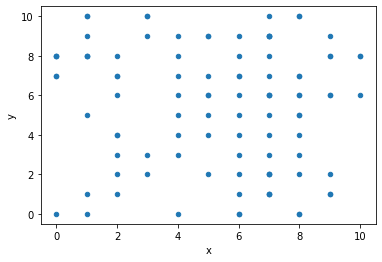

In [160]:
df_coords.plot(kind="scatter", x="x", y="y");

In [83]:
# spatialNetwork.plot2()

In [84]:
spatialNetwork.testUnconnected()

All unreported pages are connected to at least one other node via an incoming/outgoing link.


In [161]:
PageRanker.rank(spatialNetwork)

12

## Completely Random Network

In [86]:
def makeRandomNetwork(n: int = 100, successProbability: float = 0.1):
    randomNetwork= Network()

    for i in range(0,100):
        p = Page("Page {}".format(i))
        randomNetwork.addPage(p)

    for p in randomNetwork:
        for other in randomNetwork:
            # Check if equal
            if not(other.getName() == p.getName()):
                if (random.random() < successProbability):
                    other.addLinkTo(p)
                    
    return randomNetwork

In [87]:
randomNetwork = makeRandomNetwork()

In [88]:
PageRanker.rankCR(randomNetwork, 100, 0.5)
randomNetwork.showRanking()
randomNetwork.debugRanking()

Page 0: 0.009617843878137624
Page 1: 0.012099998865081297
Page 2: 0.012168582863259444
Page 3: 0.009818982948132726
Page 4: 0.009503827185399445
Page 5: 0.007855830437443853
Page 6: 0.011476755270987607
Page 7: 0.00994016844045492
Page 8: 0.01146642799244831
Page 9: 0.010086396382868778
Page 10: 0.012699765081043288
Page 11: 0.010972367296631784
Page 12: 0.009094382935916506
Page 13: 0.011309735060797146
Page 14: 0.009222128795072131
Page 15: 0.010882344897953544
Page 16: 0.010018618711037937
Page 17: 0.011747510550587236
Page 18: 0.012781219331167232
Page 19: 0.008075310977626399
Page 20: 0.009198986732540259
Page 21: 0.010726244657184525
Page 22: 0.01236146692123981
Page 23: 0.010586904219672944
Page 24: 0.010742155983038869
Page 25: 0.009711363188297649
Page 26: 0.010078855057136585
Page 27: 0.007926120866873077
Page 28: 0.010382247001604436
Page 29: 0.013147992707483078
Page 30: 0.010060622062885483
Page 31: 0.009201796053050973
Page 32: 0.010738252240279135
Page 33: 0.009539428287

In [89]:
PageRanker.rank(randomNetwork, 1000, 0.5)
randomNetwork.showRanking()
randomNetwork.debugRanking()

Page 0: 0.00961784387813753
Page 1: 0.012099998865081176
Page 2: 0.012168582863259322
Page 3: 0.009818982948132627
Page 4: 0.009503827185399355
Page 5: 0.00785583043744378
Page 6: 0.01147675527098749
Page 7: 0.009940168440454825
Page 8: 0.0114664279924482
Page 9: 0.01008639638286868
Page 10: 0.012699765081043164
Page 11: 0.010972367296631678
Page 12: 0.009094382935916417
Page 13: 0.011309735060797037
Page 14: 0.009222128795072044
Page 15: 0.010882344897953436
Page 16: 0.01001861871103784
Page 17: 0.011747510550587115
Page 18: 0.012781219331167102
Page 19: 0.008075310977626324
Page 20: 0.009198986732540172
Page 21: 0.010726244657184419
Page 22: 0.012361466921239688
Page 23: 0.010586904219672842
Page 24: 0.010742155983038761
Page 25: 0.009711363188297554
Page 26: 0.01007885505713649
Page 27: 0.007926120866873002
Page 28: 0.010382247001604334
Page 29: 0.013147992707482946
Page 30: 0.010060622062885384
Page 31: 0.009201796053050883
Page 32: 0.010738252240279031
Page 33: 0.00953942828768512

In [90]:
# randomNetwork.plot2()
# randomNetwork.testUnconnected()

In [91]:
PageRanker.rank(randomNetwork)

10

In [92]:
iterations = {}
# n = 1000
n=1
nNodes = 100
for i in range(n):
    p = i/n
    net = makeRandomNetwork(nNodes, p)
    iterations[p] = PageRanker.rank(net)

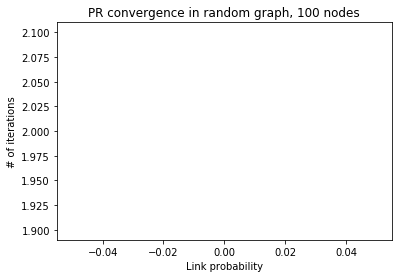

In [93]:
from scipy.ndimage.filters import gaussian_filter1d
x = list(iterations.keys())
y = list(iterations.values())

fig, ax = plt.subplots(1, 1)
# ax.plot(x, y)
ax.plot(x, gaussian_filter1d(y, sigma=2))
ax.set_xlabel("Link probability")
ax.set_ylabel("# of iterations")
ax.set_title(f'PR convergence in random graph, {nNodes} nodes');

In [94]:
# ax.get_figure().savefig("plot.pdf")

## 2WB20 Canvas Page

In [95]:
canvas = Network()
w1 = Page("Canvas Main Page")
w2 = Page("Modules")
w3 = Page("Schedule")
w4 = Page("Syllabus")
w5 = Page("Discussions")
w6 = Page("Video Lectures")
w7 = Page("Lecture Notes")
w8 = Page("Instruction Exercises")
w9 = Page("Modelling")
w10 = Page("Handouts")

w1.addLinksTo(w2, w3, w4, w5, w6)
w2.addLinksTo(w1, w6, w7, w8, w9, w10)
w3.addLinksTo(w1, w8, w10)
w4.addLinksTo(w1, w3)
w5.addLinkTo(w1)
w6.addLinkTo(w2)
w7.addLinkTo(w2)
w8.addLinkTo(w2)
w9.addLinkTo(w2)
w10.addLinkTo(w2)

canvas.addPages(w1, w2, w3, w4, w5, w6, w7, w8, w9, w10)
canvas.plot0()

'C:\Users\20182530\Anaconda3\envs\Pagerank' is not recognized as an internal or external command,
operable program or batch file.


CalledProcessError: Command '['dot.bat', '-Tsvg']' returned non-zero exit status 1. [stderr: b"'C:\\Users\\20182530\\Anaconda3\\envs\\Pagerank' is not recognized as an internal or external command,\r\noperable program or batch file.\r\n"]

In [96]:
PageRanker.rank(canvas)
canvas.showRanking()

Canvas Main Page: 0.13251670385550707
Modules: 0.26280623584636176
Schedule: 0.07906458796639339
Syllabus: 0.06325167036356727
Discussions: 0.06325167036356727
Video Lectures: 0.08515219007922678
Lecture Notes: 0.07190051971565951
Instruction Exercises: 0.08507795104702875
Modelling: 0.07190051971565951
Handouts: 0.08507795104702875


In [97]:
personalization = [0.7, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9]

In [98]:
PageRanker.rank(canvas, qis=personalization)
canvas.showRanking()

Canvas Main Page: 0.4203167533663985
Modules: 0.16877010611412083
Schedule: 0.07337292748450815
Syllabus: 0.058698341975553556
Discussions: 0.058698341975553556
Video Lectures: 0.07276251756307878
Lecture Notes: 0.030730842254191898
Instruction Exercises: 0.042959663506201395
Modelling: 0.030730842254191898
Handouts: 0.042959663506201395
